In [7]:
# Essential Imports

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [8]:
# Device Setup,Configure GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

 Using device: cuda


In [9]:
#Data Loading


#  Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths to train/val/test directories
data_dir = "./dataset_split"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

#  Class names
class_names = train_dataset.classes
print(f" Classes detected: {class_names}")


 Classes detected: ['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']


In [10]:
#Model Setup

#ResNet18
model = models.resnet18(pretrained=True)

#  Fine-tune last layers
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

#  Modify final FC layer
num_classes = len(class_names)
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

#  Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


C:\Users\chris\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chris\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
#  Cell 3: Training with Early Stopping

best_val_loss = float('inf')
patience = 3
counter = 0
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    #  Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total

     #  Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_car_damage_model.pth")
        print("✓ Model improved. Saved as 'best_car_damage_model.pth'")
    else:
        counter += 1
        print(f"× No improvement. Early stopping patience: {counter}/{patience}")
        if counter >= patience:
            print("→ Early stopping triggered. Stopping training.")
            break

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")


✓ Model improved. Saved as 'best_car_damage_model.pth'
[Epoch 1/20] Train Loss: 1.1561 | Val Loss: 0.7089 | Val Accuracy: 68.99%
✓ Model improved. Saved as 'best_car_damage_model.pth'
[Epoch 2/20] Train Loss: 0.7257 | Val Loss: 0.6171 | Val Accuracy: 73.62%
× No improvement. Early stopping patience: 1/3
[Epoch 3/20] Train Loss: 0.5890 | Val Loss: 0.6186 | Val Accuracy: 74.20%
✓ Model improved. Saved as 'best_car_damage_model.pth'
[Epoch 4/20] Train Loss: 0.4573 | Val Loss: 0.5903 | Val Accuracy: 76.23%
✓ Model improved. Saved as 'best_car_damage_model.pth'
[Epoch 5/20] Train Loss: 0.4155 | Val Loss: 0.5414 | Val Accuracy: 79.13%
× No improvement. Early stopping patience: 1/3
[Epoch 6/20] Train Loss: 0.3309 | Val Loss: 0.5814 | Val Accuracy: 76.52%
× No improvement. Early stopping patience: 2/3
[Epoch 7/20] Train Loss: 0.2575 | Val Loss: 0.6260 | Val Accuracy: 75.65%
× No improvement. Early stopping patience: 3/3
→ Early stopping triggered. Stopping training.


 Classification Report:
              precision    recall  f1-score   support

  F_Breakage       0.79      0.85      0.82        75
   F_Crushed       0.75      0.67      0.71        60
    F_Normal       0.82      0.88      0.85        75
  R_Breakage       0.78      0.78      0.78        45
   R_Crushed       0.70      0.67      0.68        45
    R_Normal       0.77      0.73      0.75        45

    accuracy                           0.78       345
   macro avg       0.77      0.76      0.76       345
weighted avg       0.77      0.78      0.77       345

 Confusion Matrix:
[[64  6  5  0  0  0]
 [14 40  6  0  0  0]
 [ 3  6 66  0  0  0]
 [ 0  1  0 35  7  2]
 [ 0  0  1  6 30  8]
 [ 0  0  2  4  6 33]]


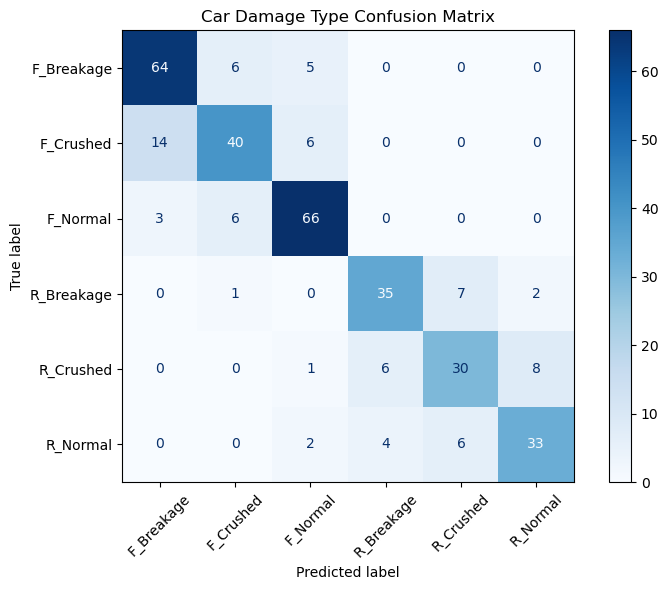

 Final model saved as car_damage_model.pth


In [12]:
# Cell 4: Evaluation & Model Saving

# Load best model
model.load_state_dict(torch.load("best_car_damage_model.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print(" Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
print(" Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Car Damage Type Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

#  Final model save
torch.save(model.state_dict(), "car_damage_model.pth")
print(" Final model saved as car_damage_model.pth")
